In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

np.set_printoptions(precision=3)

In [33]:
class Agent:
    def __init__(self):
        pass
    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 1

In [34]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.fuel_capacity = 100.0  # Maximum fuel capacity
        self.fuel_consumption_rate = 0.01  # Fuel consumption rate per unit distance
        self.reset()

    def reset(self):
        self.change_tyre(self.default_tyre)
        self.fuel_level = self.fuel_capacity
        
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        # Change car's tires
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.0
    
    
    def get_velocity(self, driving_style):
        # Calculate car velocity based on tire, condition, fuel level, and driving style
        base_velocity = 0
        if self.tyre == "Ultrasoft":
            base_velocity = 80.7
        elif self.tyre == "Soft":
            base_velocity = 80.1
        elif self.tyre == "Intermediate":
            base_velocity = 79.5
        elif self.tyre == "Fullwet":
            base_velocity = 79.0
        
        # Adjust velocity based on fuel level and driving style
        if driving_style == 1:
            velocity = base_velocity * (0.8 * self.condition**1.5) * (self.fuel_level / self.fuel_capacity)
        elif driving_style == 2:
            velocity = base_velocity * (0.6 * self.condition**1.5) * (self.fuel_level / self.fuel_capacity)
        elif driving_style == 3:
            velocity = base_velocity * (0.4 * self.condition**1.5) * (self.fuel_level / self.fuel_capacity)
        return velocity


In [35]:
class Track:
    def __init__(self, car=Car()):
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }        
        # Initialize cur_weather
        self.reset()

    def reset(self):
        # Reset track parameters
        self.radius = np.random.randint(600, 1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()

    def _get_state(self):
        # Return the current state
        return [self.car.tyre, self.car.condition, self.car.fuel_level, self.cur_weather, self.radius, self.laps_cleared]

    def transition(self, action=0, driving_style=1):
        time_taken = 0

        # Check for pitstops
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False

        # Check if an action is needed at the start of the three-quarters mark of each lap
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False

        # Update weather conditions
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )

        # Calculate distance traveled and velocity
        velocity = self.car.get_velocity(driving_style)
        distance = (2 * np.pi * self.radius / 8)

        # Add a check to avoid division by zero
        if velocity > 0:
            time_taken += distance / velocity
        else:
            # Handle the case where velocity is zero (or negative)
            time_taken += 1.0  # You can choose a default time increment when velocity is zero or negative

        # Apply degradation and fuel consumption
        self.car.degrade(w=self.wetness[self.cur_weather], r=self.radius)
        fuel_consumed = distance * self.car.fuel_consumption_rate
        self.car.fuel_level -= fuel_consumed

        reward = 0 - time_taken

        # Implement crash scenarios based on crash probability
        crash_probability = self.calculate_crash_probability(velocity)
        if np.random.random() < crash_probability:
            # Car crashes, apply a massive negative reward
            reward -= 1000

        # Implement rewards/penalties based on fuel efficiency
        if fuel_consumed > 0:
            reward -= fuel_consumed

        # Check if the race is finished
        if self.laps_cleared == self.total_laps:
            self.is_done = True

        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

    def calculate_crash_probability(self, velocity):
        # Calculate crash probability based on velocity, wetness, and other factors
        crash_probability = 0.01 * (velocity - 80) + 0.05 * self.wetness[self.cur_weather]
        return crash_probability

In [36]:
class QLearningAgent:
    def __init__(self, n_actions=5, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, fuel_level, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, int(laps_cleared))

    def act(self, state):
        discrete_state = self._discretize_state(state)
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)

In [13]:
# Simulation with Q-learning
new_car = Car()
env = Track(new_car)

agent = QLearningAgent()

EPISODES = 1000

# Define different parameter sets
parameter_sets = [
    {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.1},
    {"alpha": 0.05, "gamma": 1, "epsilon": 0.05},
    {"alpha": 0.1, "gamma": 0.8, "epsilon": 0.01},
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.03},
    {"alpha": 0.3, "gamma": 0.8, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.05},
    {"alpha": 0.3, "gamma": 0.7, "epsilon": 0.1},
    {"alpha": 0.4, "gamma": 0.85, "epsilon": 0.1},
    {"alpha": 0.3, "gamma": 0.1, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0, "epsilon": 0.1},
    {"alpha": 0.2, "gamma": 0.4, "epsilon": 0.05},
    {"alpha": 0.3, "gamma": 0.7, "epsilon": 0.1},
    {"alpha": 0.4, "gamma": 0.5, "epsilon": 0.1}
]

Episode 0/1000, Avg Reward: -8540.784790177075
Episode 100/1000, Avg Reward: -10661.185528234115
Episode 200/1000, Avg Reward: -10146.869690471387
Episode 300/1000, Avg Reward: -10336.364630990565
Episode 400/1000, Avg Reward: -13236.5478253964
Episode 500/1000, Avg Reward: -12546.298590878347
Episode 600/1000, Avg Reward: -12165.475663720039
Episode 700/1000, Avg Reward: -11768.286331262954
Episode 800/1000, Avg Reward: -11507.469871667925
Episode 900/1000, Avg Reward: -11357.342114560415
Episode 0/1000, Avg Reward: -7928.402965370808
Episode 100/1000, Avg Reward: -10267.031542510218
Episode 200/1000, Avg Reward: -10145.735712574335
Episode 300/1000, Avg Reward: -10154.214777689025
Episode 400/1000, Avg Reward: -11732.35910238468
Episode 500/1000, Avg Reward: -11630.730018624356
Episode 600/1000, Avg Reward: -11245.050575455507
Episode 700/1000, Avg Reward: -11085.200078953567
Episode 800/1000, Avg Reward: -10931.778267362755
Episode 900/1000, Avg Reward: -11448.459447183499
Episode 0

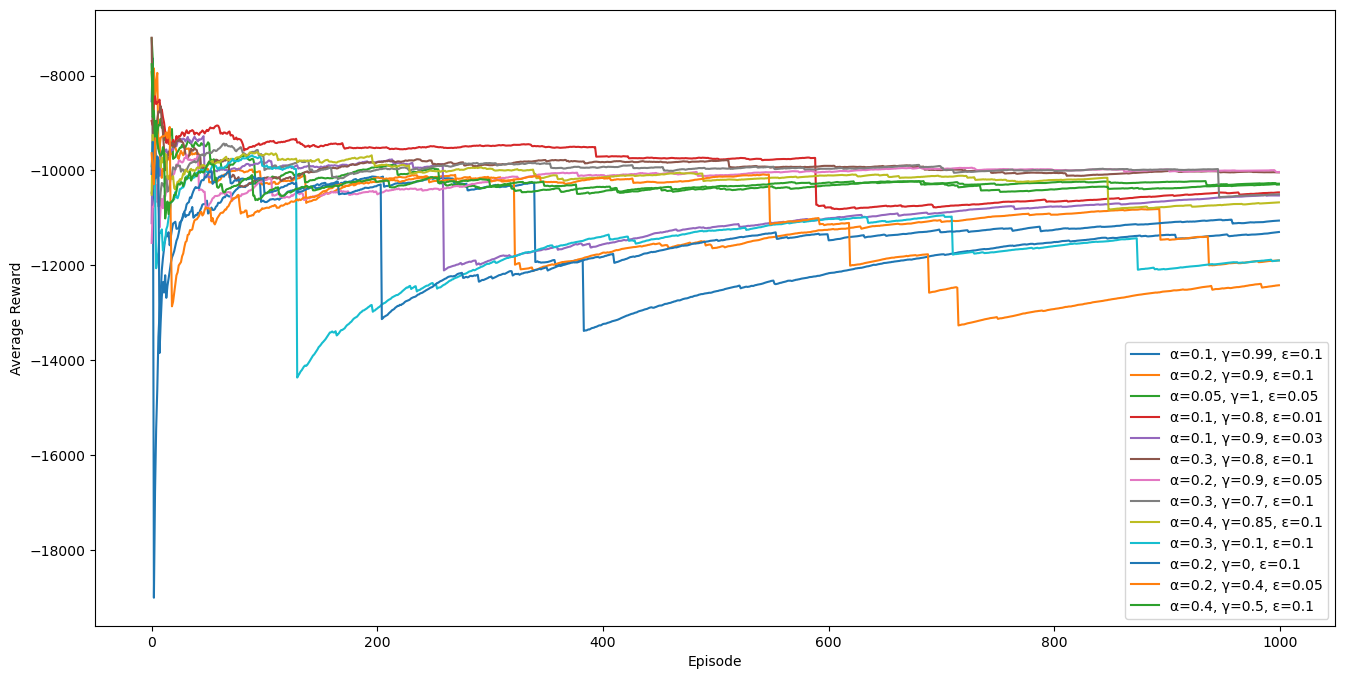

In [15]:
results = {}

for params in parameter_sets:
    # Initialize agent with current parameters
    agent = QLearningAgent(alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"])

    avg_rewards = []
    running_sum = 0
    
    for episode in range(EPISODES):
        state = env.reset()
        done = False
        G = 0

        for step in range(EPISODES):  # Use a simple step counter
            action = agent.act(state)
            reward, next_state, done, _ = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            G += reward

            if done:
                break

        running_sum += G
        avg_reward = running_sum / (episode + 1)
        avg_rewards.append(avg_reward)

        # Print progress periodically
        if episode % 100 == 0:
            print(f"Episode {episode}/{EPISODES}, Avg Reward: {avg_reward}")

    # Store average rewards for this parameter set
    param_label = f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'
    results[param_label] = avg_rewards
    
# Plot results
plt.figure(figsize=(16, 8))
for param_label, avg_rewards in results.items():
    plt.plot(avg_rewards, label=param_label)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

In [39]:
# Define a function to calculate the moving average
def moving_average(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

Episode 0/1000, Avg Reward: -7719.488922109329
Episode 100/1000, Avg Reward: -10677.96451802549
Episode 200/1000, Avg Reward: -10590.13003669564
Episode 300/1000, Avg Reward: -12302.505865555826
Episode 400/1000, Avg Reward: -11635.6832098473
Episode 500/1000, Avg Reward: -11239.303631595414
Episode 600/1000, Avg Reward: -10999.641286884189
Episode 700/1000, Avg Reward: -10803.206052430605
Episode 800/1000, Avg Reward: -10933.651447136508
Episode 900/1000, Avg Reward: -10879.26220256687
Episode 0/1000, Avg Reward: -11039.300991343514
Episode 100/1000, Avg Reward: -9751.818599759625
Episode 200/1000, Avg Reward: -12663.252062467553
Episode 300/1000, Avg Reward: -12129.174770765185
Episode 400/1000, Avg Reward: -11498.254277259772
Episode 500/1000, Avg Reward: -11202.511148021682
Episode 600/1000, Avg Reward: -11164.644317620397
Episode 700/1000, Avg Reward: -11003.95579652137
Episode 800/1000, Avg Reward: -10906.554561972665
Episode 900/1000, Avg Reward: -10758.92798887415
Episode 0/100

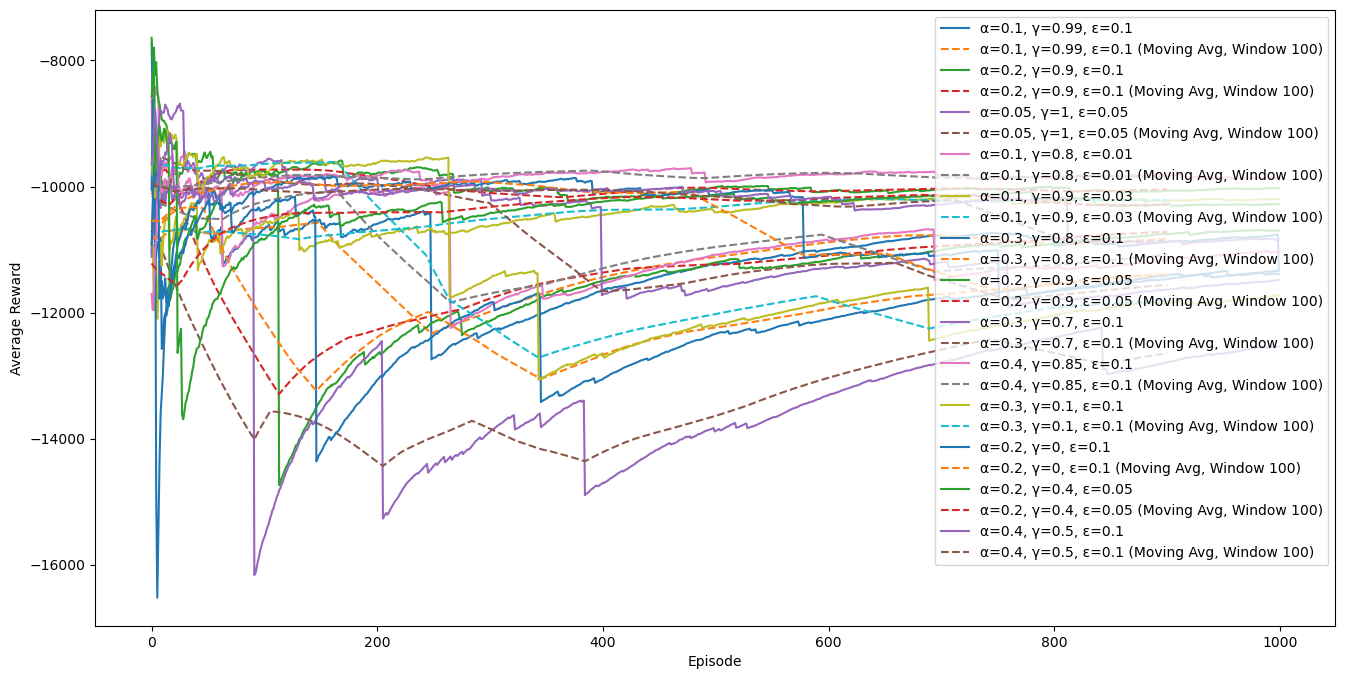

In [41]:
results = {}

for params in parameter_sets:
    # Initialize agent with current parameters
    agent = QLearningAgent(alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"])

    avg_rewards = []
    total_rewards = 0

    for episode in range(EPISODES):
        state = env.reset()
        done = False
        total_reward = 0

        for step in range(EPISODES):
            action = agent.act(state)
            reward, next_state, done, _ = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if done:
                break

        total_rewards += total_reward
        avg_reward = total_rewards / (episode + 1)
        avg_rewards.append(avg_reward)

        # Print progress periodically
        if episode % 100 == 0:
            print(f"Episode {episode}/{EPISODES}, Avg Reward: {avg_reward}")

    # Store average rewards for this parameter set
    param_label = f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'
    results[param_label] = avg_rewards

# Plot results for different parameter sets with moving average
plt.figure(figsize=(16, 8))
for param_label, avg_rewards in results.items():
    moving_avg = moving_average(avg_rewards, window_size)
    plt.plot(avg_rewards, label=param_label)
    plt.plot(moving_avg, label=param_label + f' (Moving Avg, Window {window_size})', linestyle='--')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

## Another Approach

In [42]:
class Track:
    def __init__(self, car, radius):
        self.radius = radius
        self.car = car
        self.total_laps = 162
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }        
        # Initialize cur_weather
        self.reset()

    def reset(self):
        # Reset track parameters
        self.radius = np.random.randint(600, 1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()

    def _get_state(self):
        # Return the current state
        return [self.car.tyre, self.car.condition, self.car.fuel_level, self.cur_weather, self.radius, self.laps_cleared]

    def transition(self, action=0, driving_style=1):
        time_taken = 0

        # Check for pitstops
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False

        # Check if an action is needed at the start of the three-quarters mark of each lap
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False

        # Update weather conditions
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )

        # Calculate distance traveled and velocity
        velocity = self.car.get_velocity(driving_style)
        distance = (2 * np.pi * self.radius / 8)

        # Add a check to avoid division by zero
        if velocity > 0:
            time_taken += distance / velocity
        else:
            # Handle the case where velocity is zero (or negative)
            time_taken += 1.0  # You can choose a default time increment when velocity is zero or negative

        # Apply degradation and fuel consumption
        self.car.degrade(w=self.wetness[self.cur_weather], r=self.radius)
        fuel_consumed = distance * self.car.fuel_consumption_rate
        self.car.fuel_level -= fuel_consumed

        reward = 0 - time_taken

        # Implement crash scenarios based on crash probability
        crash_probability = self.calculate_crash_probability(velocity)
        if np.random.random() < crash_probability:
            # Car crashes, apply a massive negative reward
            reward -= 1000

        # Implement rewards/penalties based on fuel efficiency
        if fuel_consumed > 0:
            reward -= fuel_consumed

        # Check if the race is finished
        if self.laps_cleared == self.total_laps:
            self.is_done = True

        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

    def calculate_crash_probability(self, velocity):
        # Calculate crash probability based on velocity, wetness, and other factors
        crash_probability = 0.01 * (velocity - 80) + 0.05 * self.wetness[self.cur_weather]
        return crash_probability

In [43]:
class QLearningAgent:
    def __init__(self, n_actions=5, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, fuel_level, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, int(laps_cleared))

    def act(self, state):
        discrete_state = self._discretize_state(state)
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)

In [44]:
# Define the radius bins
radius_bins = [(600, 700), (700, 800), (800, 900), (900, 1000), (1000, 1100), (1100, 1200)]

# Initialize lists to store average rewards for each bin
avg_rewards_by_bin = []

# Define total episodes
EPISODES = 5000

# Training strategy that divides episodes into bins based on track radius
for min_radius, max_radius in radius_bins:
    bin_episodes = EPISODES // len(radius_bins)  # Distribute episodes evenly among the bins
    bin_avg_rewards = []  # Store average rewards for this bin

    for episode in range(bin_episodes):
        random_radius = np.random.randint(min_radius, max_radius + 1)
        car = Car()
        env = Track(car, random_radius)

        state = env.reset()
        done = False
        G = 0

        for step in range(EPISODES):
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            G += reward

            if done:
                break

        bin_avg_rewards.append(G)

        if episode % 100 == 0:
            print(f"Bin: {min_radius}-{max_radius}, Episode {episode}/{bin_episodes}, Total Reward: {G}")

    avg_rewards_by_bin.append(bin_avg_rewards)

# Final 1000 episodes with random radius
final_random_rewards = []

for episode in range(1000):
    random_radius = np.random.randint(600, 1201)
    car = Car()
    env = Track(car, random_radius)

    state = env.reset()
    done = False
    G = 0

    for step in range(EPISODES):
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        G += reward

        if done:
            break

    final_random_rewards.append(G)

    if episode % 100 == 0:
        print(f"Random Radius, Episode {episode}/1000, Total Reward: {G}")

# Calculate and print average rewards for each bin
for i, (min_radius, max_radius) in enumerate(radius_bins):
    avg_reward = np.mean(avg_rewards_by_bin[i])
    print(f"Average Reward for Bin {min_radius}-{max_radius}: {avg_reward}")

# Calculate and print average rewards for the final random episodes
avg_random_reward = np.mean(final_random_rewards)
print(f"Average Reward for Random Radius Episodes: {avg_random_reward}")

Bin: 600-700, Episode 0/833, Total Reward: -31245.143128597858
Bin: 600-700, Episode 100/833, Total Reward: -50286.68327177257
Bin: 600-700, Episode 200/833, Total Reward: -32086.583754167197
Bin: 600-700, Episode 300/833, Total Reward: -49279.256358842045
Bin: 600-700, Episode 400/833, Total Reward: -48257.6598104529
Bin: 600-700, Episode 500/833, Total Reward: -37024.33400494657
Bin: 600-700, Episode 600/833, Total Reward: -32699.1004563322
Bin: 600-700, Episode 700/833, Total Reward: -45888.15523144531
Bin: 600-700, Episode 800/833, Total Reward: -40696.49720353822
Bin: 700-800, Episode 0/833, Total Reward: -32302.050365520157
Bin: 700-800, Episode 100/833, Total Reward: -46006.19270528357
Bin: 700-800, Episode 200/833, Total Reward: -47383.00337148538
Bin: 700-800, Episode 300/833, Total Reward: -33678.70145645929
Bin: 700-800, Episode 400/833, Total Reward: -30757.000471009545
Bin: 700-800, Episode 500/833, Total Reward: -31916.014582831245
Bin: 700-800, Episode 600/833, Total Rew

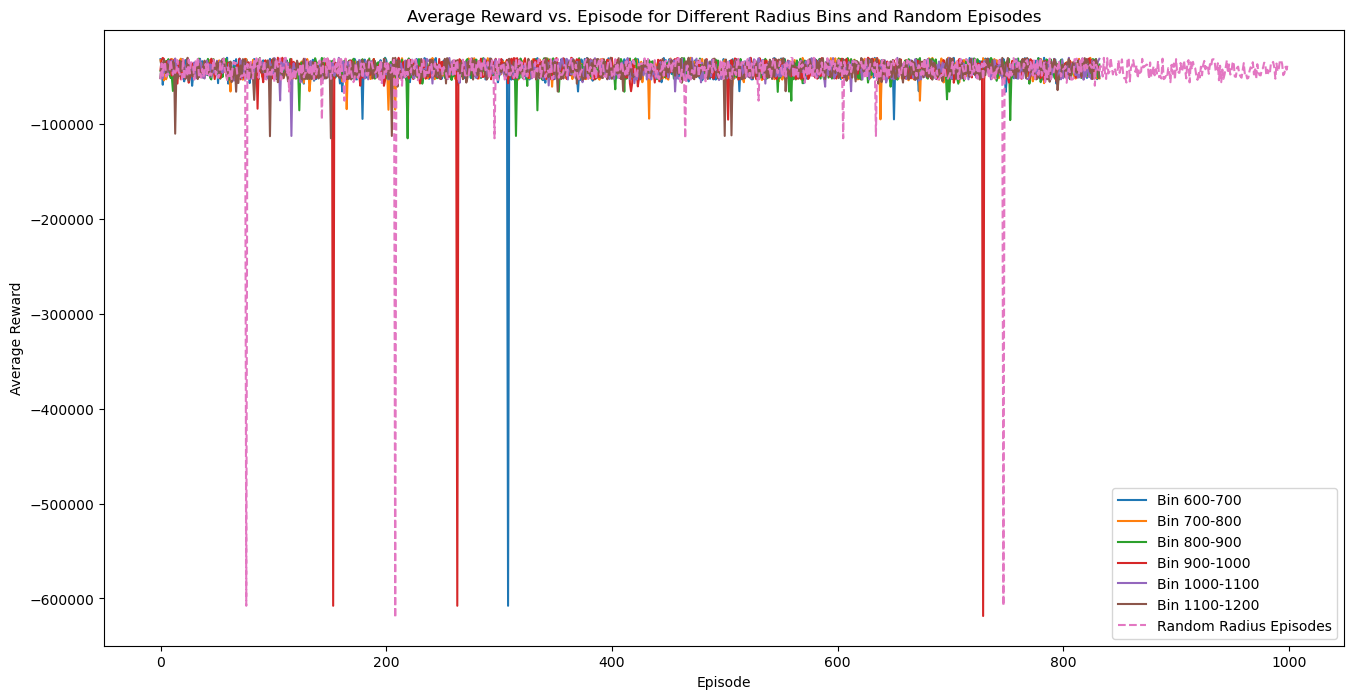

In [45]:
# Plot the results
plt.figure(figsize=(16, 8))
for (min_radius, max_radius), avg_rewards in zip(radius_bins, avg_rewards_by_bin):
    label = f"Bin {min_radius}-{max_radius}"
    plt.plot(avg_rewards, label=label)

plt.plot(final_random_rewards, label="Random Radius Episodes", linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.title('Average Reward vs. Episode for Different Radius Bins and Random Episodes')
plt.show()

## Approach 3

In [22]:
class Track:
    def __init__(self, car, radius, total_laps=162):
        self.radius = radius
        self.car = car
        self.total_laps = total_laps
        self.laps_cleared = 0  # Initialize laps cleared
        self.is_done = False
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }        
        # Initialize car's state
        self.car.reset()
    def reset(self):
        # Reset track parameters
        self.radius = np.random.randint(600, 1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()

    def _get_state(self):
        # Return the current state
        return [self.car.tyre, self.car.condition, self.car.fuel_level, self.cur_weather, self.radius, self.laps_cleared]

    def transition(self, action=0, driving_style=1):
        time_taken = 0

        # Check for pitstops
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False

        # Check if an action is needed at the start of the three-quarters mark of each lap
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False

        # Update weather conditions
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )

        # Calculate distance traveled and velocity
        velocity = self.car.get_velocity(driving_style)
        distance = (2 * np.pi * self.radius / 8)

        # Add a check to avoid division by zero
        if velocity > 0:
            time_taken += distance / velocity
        else:
            # Handle the case where velocity is zero (or negative)
            time_taken += 1.0  # You can choose a default time increment when velocity is zero or negative

        # Apply degradation and fuel consumption
        self.car.degrade(w=self.wetness[self.cur_weather], r=self.radius)
        fuel_consumed = distance * self.car.fuel_consumption_rate
        self.car.fuel_level -= fuel_consumed

        reward = 0 - time_taken

        # Implement crash scenarios based on crash probability
        crash_probability = self.calculate_crash_probability(velocity)
        if np.random.random() < crash_probability:
            # Car crashes, apply a massive negative reward
            reward -= 1000

        # Implement rewards/penalties based on fuel efficiency
        if fuel_consumed > 0:
            reward -= fuel_consumed

        # Check if the race is finished
        if self.laps_cleared == self.total_laps:
            self.is_done = True

        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

    def calculate_crash_probability(self, velocity):
        # Calculate crash probability based on velocity, wetness, and other factors
        crash_probability = 0.01 * (velocity - 80) + 0.05 * self.wetness[self.cur_weather]
        return crash_probability

In [23]:
class QLearningAgent:
    def __init__(self, n_actions=5, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        
    def _discretize_state(self, state):
        tyre, condition, fuel_level, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, int(laps_cleared))

    def act(self, state):
        discrete_state = self._discretize_state(state)
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)

In [25]:
# Training strategy that divides episodes into bins based on track radius
radius_bins = [(600, 700), (700, 800), (800, 900), (900, 1000), (1000, 1100), (1100, 1200)]

# Initialize lists to store average rewards for each bin
avg_rewards_by_bin = []

# Define total episodes
EPISODES = 5000

# Training strategy
for min_radius, max_radius in radius_bins:
    bin_episodes = 1000  # Number of episodes in each bin
    bin_avg_rewards = []  # Store average rewards for this bin

    for episode in range(bin_episodes):
        random_radius = np.random.randint(min_radius, max_radius + 1)
        car = Car()
        env = Track(car, random_radius)

        state = env.reset()
        done = False
        G = 0

        for step in range(EPISODES):
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            G += reward

            if done:
                break

        bin_avg_rewards.append(G)

        if episode % 100 == 0:
            print(f"Bin: {min_radius}-{max_radius}, Episode {episode}/{bin_episodes}, Total Reward: {G}")

    avg_rewards_by_bin.append(bin_avg_rewards)

# Final 1000 episodes with random radius
final_random_rewards = []

for episode in range(1000):
    random_radius = np.random.randint(600, 1201)
    car = Car()
    env = Track(car, random_radius)

    state = env.reset()
    done = False
    G = 0

    for step in range(EPISODES):
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        G += reward

        if done:
            break

    final_random_rewards.append(G)

    if episode % 100 == 0:
        print(f"Random Radius, Episode {episode}/1000, Total Reward: {G}")

# Calculate and print average rewards for each bin and for the final random episodes
for i, (min_radius, max_radius) in enumerate(radius_bins):
    avg_reward = np.mean(avg_rewards_by_bin[i])
    print(f"Average Reward for Bin {min_radius}-{max_radius}: {avg_reward}")

# Calculate and print average rewards for the final random episodes
avg_random_reward = np.mean(final_random_rewards)
print(f"Average Reward for Random Radius Episodes: {avg_random_reward}")

Bin: 600-700, Episode 0/1000, Total Reward: -47340.0841766547
Bin: 600-700, Episode 100/1000, Total Reward: -49434.02363379203
Bin: 600-700, Episode 200/1000, Total Reward: -48572.72290175244
Bin: 600-700, Episode 300/1000, Total Reward: -32143.352842418164
Bin: 600-700, Episode 400/1000, Total Reward: -47418.86049857477
Bin: 600-700, Episode 500/1000, Total Reward: -34532.02551278952
Bin: 600-700, Episode 600/1000, Total Reward: -41396.667764107726
Bin: 600-700, Episode 700/1000, Total Reward: -52020.38692311777
Bin: 600-700, Episode 800/1000, Total Reward: -45084.97599808556
Bin: 600-700, Episode 900/1000, Total Reward: -50286.68327177257
Bin: 700-800, Episode 0/1000, Total Reward: -51490.15308826497
Bin: 700-800, Episode 100/1000, Total Reward: -40759.20929627005
Bin: 700-800, Episode 200/1000, Total Reward: -52150.76249748444
Bin: 700-800, Episode 300/1000, Total Reward: -51377.0708049605
Bin: 700-800, Episode 400/1000, Total Reward: -32594.990205473317
Bin: 700-800, Episode 500/10

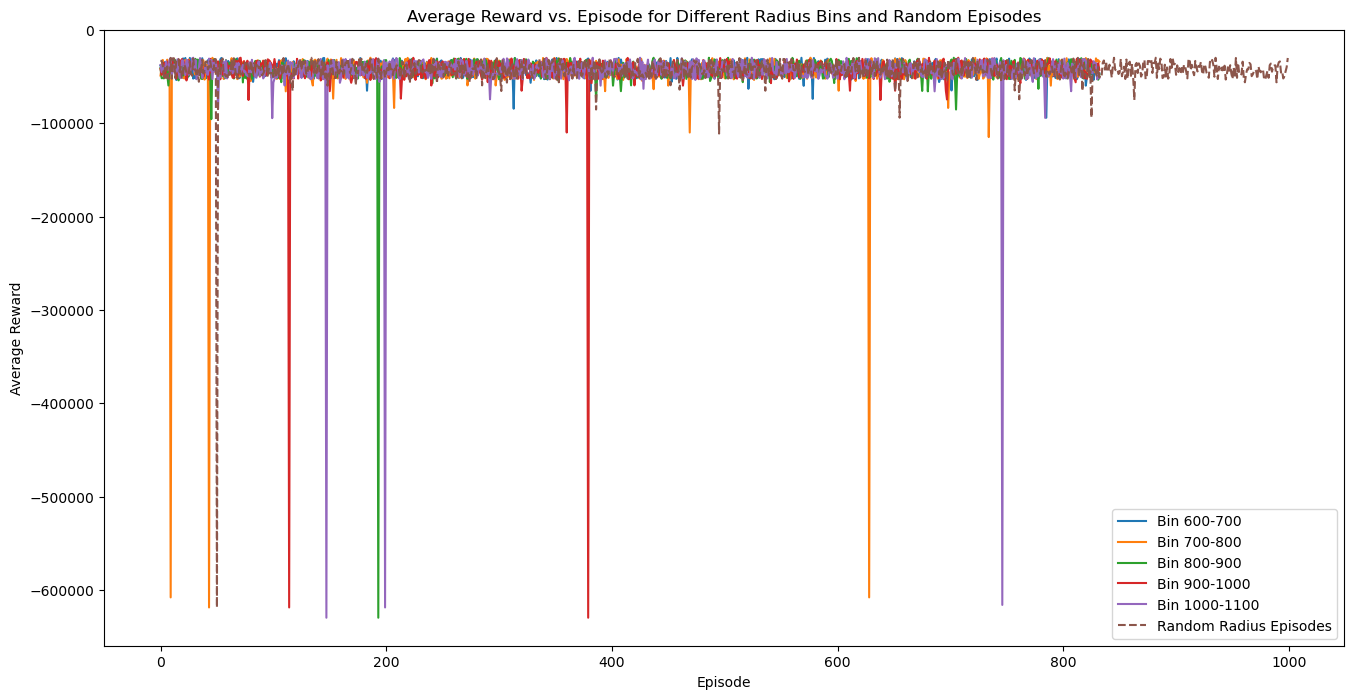

In [29]:
# Plot the results
plt.figure(figsize=(16, 8))
for (min_radius, max_radius), avg_rewards in zip(radius_bins, avg_rewards_by_bin):
    label = f"Bin {min_radius}-{max_radius}"
    plt.plot(avg_rewards, label=label)

plt.plot(final_random_rewards, label="Random Radius Episodes", linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.title('Average Reward vs. Episode for Different Radius Bins and Random Episodes')
plt.show()

### {"alpha": 0.3, "gamma": 0.8, "epsilon": 0.1} would generate higher average reward, we choose it as our parameter.

In [8]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

In [9]:
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
 
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

In [10]:
class QLearningAgent:
    # modify the parameter here
    def __init__(self, n_actions=5, alpha=0.3, gamma=0.8, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, laps_cleared)

    def act(self, state):
        discrete_state = self._discretize_state(state)
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)

100%|██████████| 1000/1000 [01:05<00:00, 15.30it/s]


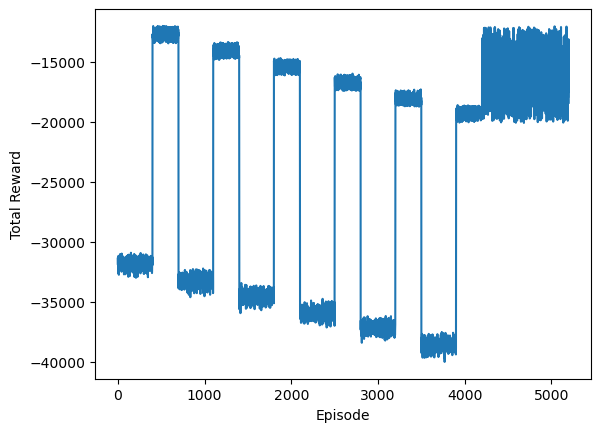

In [12]:
# Simulation with Q-learning and modified strategy
new_car = Car()
env = Track(new_car)

agent = QLearningAgent()

EPISODES = 4000
rewards = []
time_per_lap = []

radius_bins = [(600 + i*100, 600 + (i+1)*100) for i in range(6)]

for bin_idx, (start_radius, end_radius) in enumerate(radius_bins):
    for episode in tqdm(range(700)):
        # Set radius according to bin       
        state = env.reset()
        env.radius = np.random.randint(start_radius, end_radius)
        done = False
        G = 0
        local_time_per_lap = []
        while not done:
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            time_for_current_lap = (2*np.pi*env.radius/8) / velocity
            local_time_per_lap.append(time_for_current_lap)
            
            # Augmented reward condition
            if episode < 400:  # First 400 out of 500
                if done:
                    reward += 500
                elif len(local_time_per_lap) > 8:
                    if local_time_per_lap[-1] > np.mean(local_time_per_lap[-9:-1]):
                        reward -= 50
                    else:
                        reward += 20
            
            agent.update(state, action, reward, next_state)
            state = deepcopy(next_state)
            G += reward
        
        time_per_lap.append(local_time_per_lap)
        rewards.append(G)
        
# Last 1000 episodes with random radii
for episode in tqdm(range(1000)):
    state = env.reset()  # Reset with random radius
    done = False
    G = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.transition(action)
        agent.update(state, action, reward, next_state)
        state = deepcopy(next_state)
        G += reward
    rewards.append(G)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

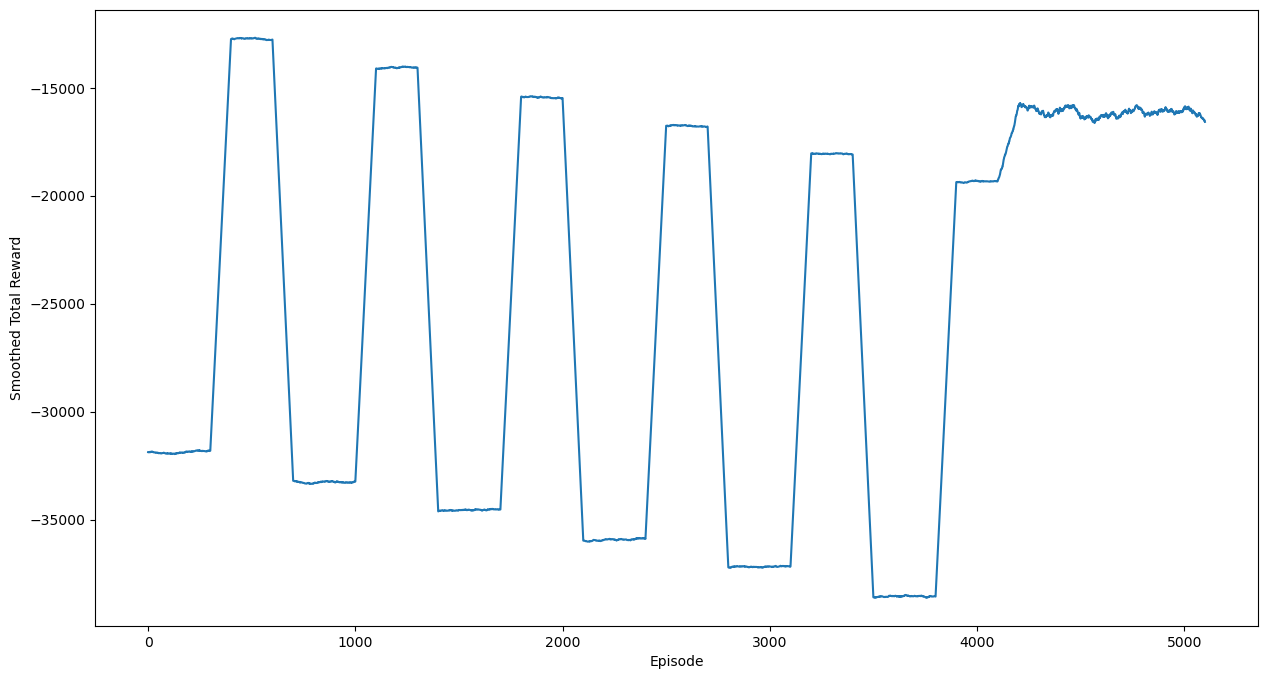

In [13]:
def moving_average(values, window_size):
    """Calculate moving average with a given window size."""
    cumsum = np.cumsum(values)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size
# Plotting smoothed rewards using moving average
WINDOW_SIZE = 100  # you can adjust this based on how smooth you want the curve
smoothed_rewards = moving_average(rewards, WINDOW_SIZE)

plt.figure(figsize=(15,8))
plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.show()

In [14]:
with open('task1_q_table.pkl', 'wb') as f:
    pickle.dump(agent.q_table, f)
    
with open('task1_q_table.pkl', 'rb') as f:
    loaded_q_table = pickle.load(f)

## Import the q_table to show the training result

100%|██████████| 1000/1000 [00:52<00:00, 18.89it/s]


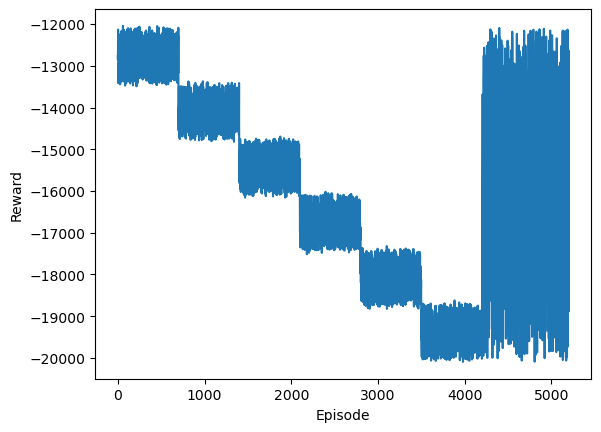

In [15]:
# Use the loaded Q-table when initializing the agent
agent = QLearningAgent(epsilon=0)
agent.q_table = loaded_q_table

# [The rest of the simulation code stays the same]
new_car = Car()
env = Track(new_car)

rewards = []
radius_bins = [(600 + i*100, 600 + (i+1)*100) for i in range(6)]

for bin_idx, (start_radius, end_radius) in enumerate(radius_bins):
    for episode in tqdm(range(700)):
        state = env.reset()
        env.radius = np.random.randint(start_radius, end_radius)
        done = False
        G = 0
        while not done:
            action = agent.act(state)
            reward, next_state, done, _ = env.transition(action)
            state = deepcopy(next_state)
            G += reward
        rewards.append(G)

# Last 1000 episodes with random radii
for episode in tqdm(range(1000)):
    state = env.reset()  # Reset with random radius
    done = False
    G = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.transition(action)
        state = deepcopy(next_state)
        G += reward
    rewards.append(G)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

## Race 1

In [16]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 600               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -12007.40
G: -12009.08
G: -12009.42
G: -12013.81
G: -12009.75
G: -12009.32
G: -12017.20
G: -12014.12
G: -12016.83


## Race 2

In [17]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]
print(start_weather,radius)

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 700               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

40% Wet 634
G: -13453.06
G: -13454.08
G: -13453.89
G: -13453.23
G: -13453.43
G: -13453.76
G: -13453.38
G: -13453.64
G: -13453.65


## Race 3

In [18]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 800               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -14772.96
G: -14774.70
G: -14773.80
G: -14771.64
G: -14773.95
G: -14773.17
G: -14773.68
G: -14774.22
G: -14773.17


## Race 4

In [19]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 900               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -16134.00
G: -16134.78
G: -16135.25
G: -16135.26
G: -16135.36
G: -16134.29
G: -16134.50
G: -16134.74
G: -16135.45


## Race 5 

In [20]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 1000               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -17465.16
G: -17465.90
G: -17465.08
G: -17463.66
G: -17465.30
G: -17465.76
G: -17464.89
G: -17465.56
G: -17466.40


## Race 6 

In [21]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius =1100               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -18790.35
G: -18806.18
G: -18789.53
G: -18787.03
G: -18791.25
G: -18783.29
G: -18803.23
G: -18792.21
G: -18791.03


## Race 7 

In [22]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 1200               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -20016.14
G: -20015.35
G: -20016.17
G: -20018.14
G: -20017.17
G: -20016.68
G: -20017.14
G: -20016.96
G: -20016.19


### another try of the modify the augement

In [23]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

In [24]:
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
    
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity


In [25]:
class QLearningAgent:
    # modify the parameter here
    def __init__(self, n_actions=5, alpha=0.3, gamma=0.8, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, laps_cleared)

    def act(self, state):
        discrete_state = self._discretize_state(state)
        if discrete_state[4] >160:
            return 4
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)


100%|██████████| 1000/1000 [01:06<00:00, 15.08it/s]


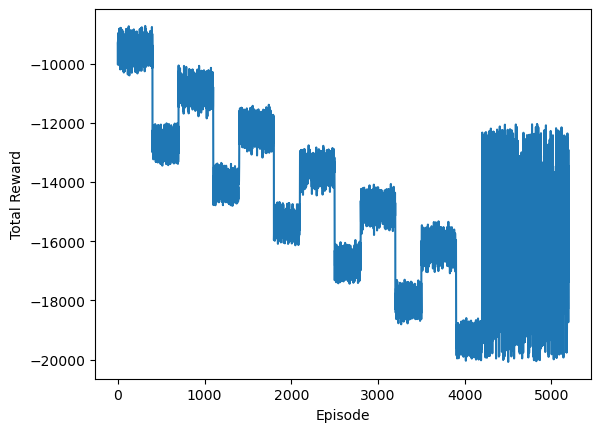

In [26]:
# Simulation with Q-learning and modified strategy
new_car = Car()
env = Track(new_car)

agent = QLearningAgent()

# EPISODES = 4000
rewards = []
time_per_lap = []

radius_bins = [(600 + i*100, 600 + (i+1)*100) for i in range(6)]

for bin_idx, (start_radius, end_radius) in enumerate(radius_bins):
    for episode in tqdm(range(700)):
        # Set radius according to bin       
        state = env.reset()
        env.radius = np.random.randint(start_radius, end_radius)
        done = False
        G = 0
        local_time_per_lap = []
        while not done:
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            time_for_current_lap = (2*np.pi*env.radius) / velocity
            local_time_per_lap.append(time_for_current_lap)
            
            # Augmented reward condition
            if episode < 400:  # First 400 out of 500
                if done:
                    reward += 10000
                elif len(local_time_per_lap) > 9:
                    if local_time_per_lap[-1] > np.mean(local_time_per_lap[-10:-1]):
                        reward -= 30
                    else:
                        reward += 20
            
            agent.update(state, action, reward, next_state)
            state = deepcopy(next_state)
            G += reward
        
        time_per_lap.append(local_time_per_lap)
        rewards.append(G)
        
# Last 1000 episodes with random radii
for episode in tqdm(range(1000)):
    state = env.reset()  # Reset with random radius
    done = False
    G = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.transition(action)
        agent.update(state, action, reward, next_state)
        state = deepcopy(next_state)
        G += reward
    rewards.append(G)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()